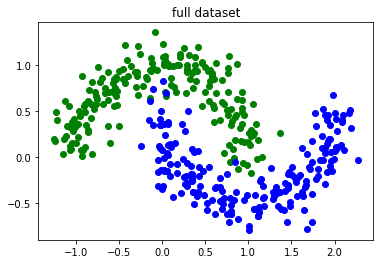

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import math

# ========================================================================
# dataset

n_tot = 400
n = int(n_tot/2)
# two moons, not really linearly separable
X, y = make_moons(n_tot, noise=0.15, random_state=0)

plt.figure()
colors = ["g", "b"]
for ii in range(2):
    class_indices = np.where(y==ii)[0]
    plt.scatter(X[class_indices, 0], X[class_indices, 1], c=colors[ii])
plt.title("full dataset")
plt.show()

# divide data into training and testing
np.random.seed(42)
order = np.random.permutation(n_tot)
train = order[:n]
test = order[n:]

Xtr = X[train, :]
ytr = y[train]
Xtst = X[test, :]
ytst = y[test]

# ========================================================================
# classifier

# The perceptron algorithm will be encountered later in the course
# How exactly it works is not relevant yet, it's enough to just know it's a binary classifier
from sklearn.linear_model import Perceptron as binary_classifier

# It can be used like this:
bc = binary_classifier()
bc.fit(Xtr, ytr)  # this is how to train the classifier on training data
preds = bc.predict(Xtst)  # this is how to obtain predictions on test data




In [13]:
# =================================
# Setup for analyzing the Rademacher complexity
ns = np.array(range(20, n+1, 20))
# when analyzing Rademacher complexity, take always n first saples from the training set, n as in this array
delta = 0.05
print_at_n = [20,50,100,200]

# =================================
# setup for VC bound

vcd = 3 # vc dimension of perceptron: data has two features, VC_dim = d + 1

In [14]:
def get_rademacher_bound(eerror, erc, n, delta):
    """
    param eerror: empirical error
    param erc: empirical rademacher complexity
    param n: numer of training samples
    param delta: delta
    """
    return eerror + erc + np.sqrt(np.log(2/delta)/(2*n))

def get_vc_bound(eerror, vcd, n, delta):
    """
    param eerror: empirical error
    param vcd: the vc dimension
    param n: numer of training samples
    param delta: delta
    """
    from math import e
    return eerror * np.sqrt((2 * vcd * np.log((e * n)/vcd))/n) + np.sqrt((np.log(1/delta))/(2 * n))

(using 25 random labelings to calculate R.complexity)
  n - Radem. - Vcdim
 20-  0.68 -  0.55
100-  0.39 -  0.24
200-  0.38 -  0.20

(using 50 random labelings to calculate R.complexity)
  n - Radem. - Vcdim
 20-  0.67 -  0.55
100-  0.40 -  0.24
200-  0.39 -  0.20

(using 75 random labelings to calculate R.complexity)
  n - Radem. - Vcdim
 20-  0.69 -  0.55
100-  0.38 -  0.24
200-  0.39 -  0.20

(using 100 random labelings to calculate R.complexity)
  n - Radem. - Vcdim
 20-  0.69 -  0.55
100-  0.39 -  0.24
200-  0.39 -  0.20

(using 1000 random labelings to calculate R.complexity)
  n - Radem. - Vcdim
 20-  0.68 -  0.55
100-  0.38 -  0.24
200-  0.39 -  0.20



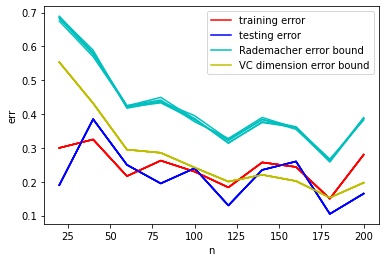

In [16]:
np.random.seed(2) # random seed can be set here to different values in order to judge the variance in R.bound

colors = ["r", "b","c","y"]
plt.figure()
ax1 = plt.gca()

#This loop is for different numbers of random labelings 
# in calculating the R.complexity
# This is just to show how the results behave: 
# the more random labelings used, the less variability 
# is there in results 
# (other calculations are also done in the loop just for 
# clarity of keeping everything together, but e.g. vc dimension 
# is not affected by the loop and to be more efficient should be calculated outside)

for random_labeling_index, n_random_labelings in enumerate([25, 50, 75, 100, 1000]):

    print("(using %d random labelings to calculate R.complexity)" % n_random_labelings) 
    print("%3s - %5s - %5s" % ("n", "Radem.", "Vcdim"))
    # collect the relevant results into arrays for plotting
    training_errors = []
    test_errors= []
    rademachers = []
    vcdims = []
    for n in ns:
        # -------------------------------------------
        # get empirical error on training and test data
        bc = binary_classifier()
        bc.fit(Xtr[:n, :], ytr[:n])
        training_error = np.count_nonzero(bc.predict(Xtr[:n,:]) - ytr[:n]) / n
        test_error = np.count_nonzero(bc.predict(Xtst) - ytst) / len(ytst)
        # many ways to implement calculating error; e.g. sklearn.metrics.zero_one_loss could also be used
        tr_preds = bc.predict(Xtr[:n, :])
        # -----------------------------------------------
        # in order to calculate the empirical rademacher complexity we need to randomize the labels: random_errors = []
        random_errors = []
        for k in range (n_random_labelings):
            new_labels = np.round(np.random.rand(n)) # create new random labels
            bc = binary_classifier()
            bc.fit(Xtr[:n], new_labels)
            random_errors.append(np.count_nonzero(bc.predict(Xtr[:n]) - new_labels) / n)
        
        # -----------------------------------------------
        training_errors.append(training_error)
        test_errors.append(test_error)
        rademachers.append(get_rademacher_bound(training_error, 0.5-np.mean(random_errors), n, delta)) 
        vcdims.append(get_vc_bound(training_error, vcd, n, delta))
        if n in print_at_n:
            print("%3d- %5.2f - %5.2f" % (n, rademachers[-1], vcdims[-1]))
    
    import matplotlib.pyplot as plt

    if n_random_labelings==25:
        ax1.plot(ns, training_errors, c=colors[0], label="training error")
        ax1.plot(ns, test_errors, c=colors[1], label="testing error")
        
        ax1.plot(ns, rademachers, c=colors [2], label="Rademacher error bound") 
        ax1.plot(ns, vcdims, c=colors[3], label="VC dimension error bound")
    else:
        ax1.plot(ns, training_errors, c=colors[0])
        ax1.plot(ns, test_errors, c=colors[1])
        ax1.plot(ns, rademachers, c=colors[2])
        ax1.plot(ns, vcdims, c=colors[3])
    
    print()
    
ax1.legend()
ax1.set_xlabel("n")
ax1.set_ylabel("err")
plt.show()
    